Epoch 1/10, Loss: 0.1092
Validation Loss: 0.0653, Accuracy: 0.9707
Model saved!
Epoch 2/10, Loss: 0.0208
Validation Loss: 0.1109, Accuracy: 0.9732
Model saved!
Epoch 3/10, Loss: 0.0534
Validation Loss: 0.1412, Accuracy: 0.9683
Epoch 4/10, Loss: 0.0109
Validation Loss: 0.0996, Accuracy: 0.9732
Epoch 5/10, Loss: 0.0110
Validation Loss: 0.1424, Accuracy: 0.9659
Epoch 6/10, Loss: 0.0426
Validation Loss: 0.0903, Accuracy: 0.9756
Model saved!
Epoch 7/10, Loss: 0.0042
Validation Loss: 0.2711, Accuracy: 0.9512
Epoch 8/10, Loss: 0.0198
Validation Loss: 0.1564, Accuracy: 0.9585
Epoch 9/10, Loss: 0.0032
Validation Loss: 0.2111, Accuracy: 0.9585
Epoch 10/10, Loss: 0.0333
Validation Loss: 0.0969, Accuracy: 0.9732
Best Validation Accuracy: 0.9756


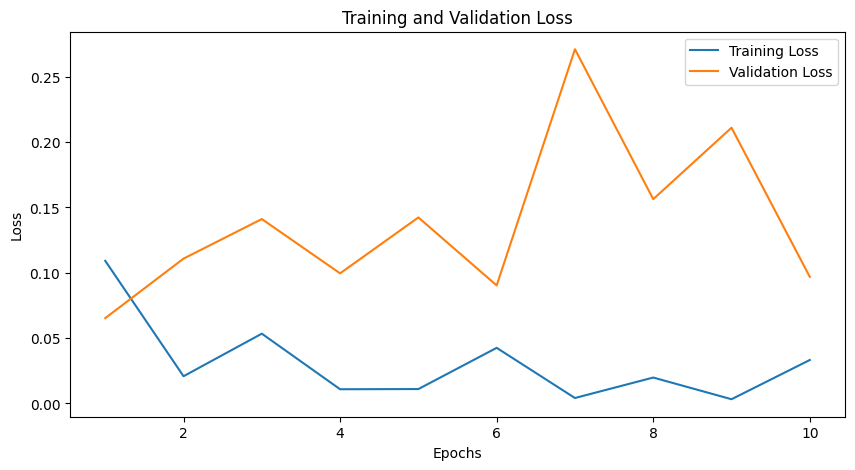

Test Loss: 0.1038, Test Accuracy: 0.9726
Confusion Matrix:
[[871  24]
 [ 27 940]]


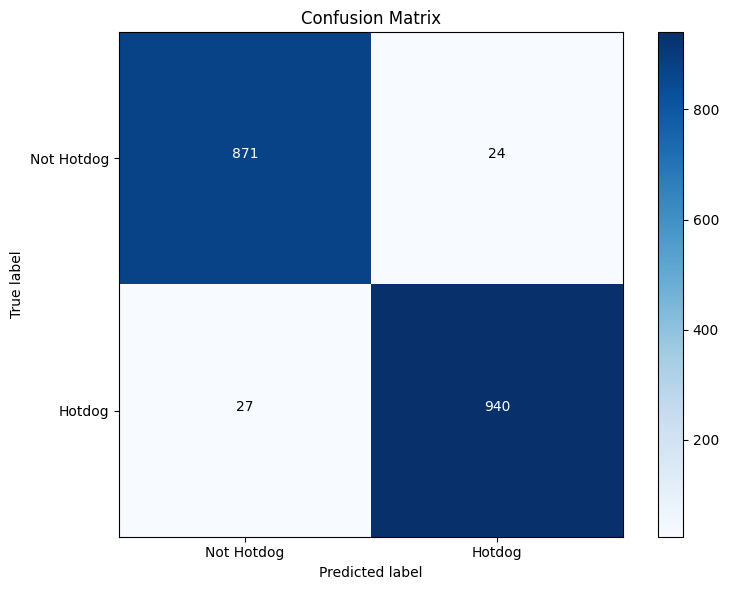

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
import matplotlib.pyplot as plt

# Define transformations for the training, validation, and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_val_dataset = datasets.ImageFolder(root='C:/Users/nicla/DTU/Computervision/1st Poster/hotdog_nothotdog/train', transform=transform)
test_dataset = datasets.ImageFolder(root='C:/Users/nicla/DTU/Computervision/1st Poster/hotdog_nothotdog/test', transform=transform)

# Define the size of the training and validation sets
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the Vision Transformer model
model_name = "google/vit-base-patch16-224"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, ignore_mismatched_sizes=True)

# flaten and output
model.classifier = nn.Sequential(
    nn.Linear(model.config.hidden_size, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 2)
)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99))

# Train
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
val_losses = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    # Val
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct.double() / len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    
    # safe model if
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")

# Final evaluation
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test the model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = 0.0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct.double() / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calculate and print confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Hotdog', 'Hotdog'])
plt.yticks(tick_marks, ['Not Hotdog', 'Hotdog'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()